# About this Notebook

This notebook aims to use the `pyphi` package to calculate $\Phi$\* values using IIT 3.0 from neural recording data obtained with five stimuli - upright faces, inverse faces, houses, tools and Mondrians. 

Written by Jamin Wu 2017/01/09, updated 2017/01/18

# Loading Packages

In [1]:
import pyphi as pyphi
import numpy as np
from collections import Counter
import scipy.io as sio
import matplotlib.pyplot as plt
import sklearn.preprocessing as skp
import matplotlib.pylab as pylab
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle

%matplotlib inline

# Loading Data

In [2]:
data_187 = sio.loadmat("../data/153_4sessions_li187.mat")
data_294 = sio.loadmat("../data/153_4sessions_li294.mat")

The main data is stored under the "allERP" key of the data dictionaries. 

In [3]:
print(data_187["allERP"].shape)
print(data_187["allERP"][0, 0].shape)

(1, 5)
(118, 3054)


Remember: python uses 0-based indexing (i.e. the first element is at index 0. This can take some time getting used to if coming from something like Matlab, R or Julia - which all use 1-based indexing.

A good way to think about 0-based index is to think of the index as an "offset" - i.e. an offset of 0 indicates the 1st element, an offset of 1 indicates the second element etc.

# Example: Upright Faces $\Phi$

Throughout this example section, I'll be defining new functions that we'll later use for the other data (inverse, houses, tools, Mondrians). These functions will be specific to the features of the data collection here - i.e. 3054 samples at 2034.5Hz - and are thus not totally generalisable outside this dataset. It should not be too difficult to make them generalisable, however. 

## Getting the Data

Let's get the ERP for all the trials within the upright faces. We'll need all the trials because - well, as we'll see, we need all the trials we can get our hands on to make what we're doing reasonable.

In [4]:
data_X = data_187["allERP"][0, 0][:, :]
data_Y = data_294["allERP"][0, 0][:, :]

data_X.shape

(118, 3054)

## Shuffling the Data

We will be binning trials into 7-trial bins as with our demo $\Phi$\* calculations; it will thus be convenient to make a small function to shuffle a dataset's trials.

In [5]:
def shuffle_data(data):
    """
    Shuffles the trials in data.
    data MUST be a trial x sample numpy array.
    """
    
    shuffled_data = np.random.permutation(data)
    
    return shuffled_data    

## Plotting Raw ERPs

Let's just get an idea of how this example data looks like at the moment - we'll plot the mean ERP over time. 

In [6]:
def plot_mean_erp(data_X, data_Y, stimulus_string):
    """
    Plots the mean ERP across all trials. X axis is labelled by sample at the moment.
    Plots both channels.
    data_X and data_Y are trial x sample numpy arrays of ERP values.
    Stimulus string is string for the title of the plot (e.g. "Upright Face", "House")
    """

    f, (p1, p2) = plt.subplots(2, sharex=True, sharey=True)
    
    # We know the number of samples is 3054
    # Otherwise, this should be changed
    time_values = np.arange(0, 3054)

    mean_X = data_X.mean(axis=0)
    mean_Y = data_Y.mean(axis=0)

    std_X = data_X.std(axis=0)
    std_Y = data_Y.std(axis=0)

    p1.plot(time_values, mean_X)
    p1.fill_between(time_values, mean_X - std_X, mean_X + std_X, alpha=0.5, linewidth=0)
    p1.set_ylabel("Channel X")
    p1.set_title("Mean and Standard Deviation across Trials\n{} Stimulus".format(stimulus_string))

    p2.plot(time_values, mean_Y)
    p2.fill_between(time_values, mean_Y - std_Y, mean_Y + std_Y, alpha=0.5, linewidth=0)
    p2.set_ylabel("Channel Y")
    p2.set_xlabel("Sample (Sampling Rate 2034.5Hz)")

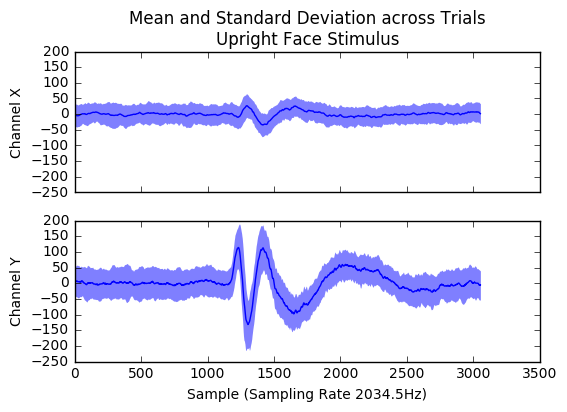

In [7]:
plot_mean_erp(data_X, data_Y, "Upright Face")

Let's also just see what it looks like on one raw trial:

In [8]:
def plot_raw_erp(data_X, data_Y, stimulus_string, idx_trial):
    """
    Plots the raw ERP for a single trial for two channels X and Y.
    data_X and data_Y are trial x sample numpy arrays of ERP values.
    Stimulus string is string for the title of the plot (e.g. "Upright Face", "House")
    idx_trial is the index of the trial to be plotted.
    """
    
    f, (p1, p2) = plt.subplots(2, sharex=True, sharey=True)

    time_values = np.arange(0, 3054)

    p1.plot(time_values, data_X[idx_trial, :])
    p1.set_ylabel("Channel X")
    p1.set_title("Raw ERP, Trial {}\n{} Stimulus".format(str(idx_trial + 1), stimulus_string))

    p2.plot(time_values, data_Y[idx_trial, :])
    p2.set_ylabel("Channel Y")
    p2.set_xlabel("Sample")

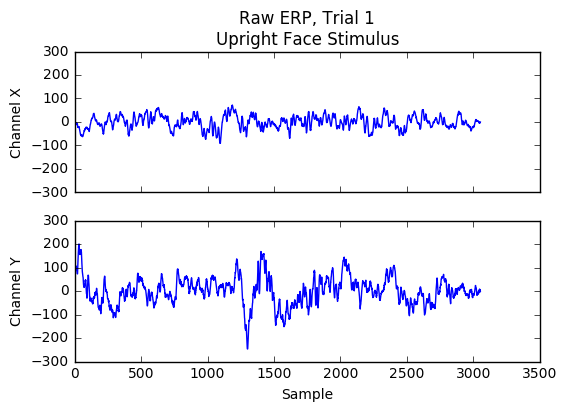

In [9]:
plot_raw_erp(data_X, data_Y, "Upright Face", 0)

## Calculating TPMs

Now the difficult part is trying to think of a good way to translate these signals into a transition probability matrix (TPM) for use in `pyphi`. 

In `pyphi`, TPMs must be in the form state by node, or state by state (with the constraint that the present state of one node is independent of the present state of another node, given a past state). 

A very simple way is to binarise the ERP data for all samples, then compute probabilities at all sample points. Let's just see how this goes for now.

We first need to specify time bin widths and time lags similar to how we computed $\Phi$\*. This will allows us to calculate $\Phi_{3.0}$ at different time "points" (or bins). To keep this consistent with how we have done this before, we will use $T = 200$ms (i.e. 406 samples) and $\tau = 3$ms (i.e. 6 samples)

In [10]:
T = 406
tau = 6

I will show two different binarisation methods below.

### Binarising the Data

The first is a simple median split. To binarise this signal, we will indicate the signal to be on if it is above the *global* median (i.e. across all trials for that stimulus category), and off if it is below. This is quite an easy binarisation method to implement.

In [11]:
def binarise_data_median(data):
    """
    data: trial x sample numpy array
    RETURNS trial x sample integer binary array
    """
    
    global_median = np.median(data)
    data_binary_float = skp.binarize(data, global_median)
    
    # Convert to integers (from float)
    data_binary_int = data_binary_float.astype(int)
    
    return data_binary_int

The second is a little more involved, and a little arbitrary-feeling. We will take the absolute consecutive ERP differences between samples; we then take the mean of these absolute differences and define any values above the mean of the absolute difference to be "on", and below to be "off". 

In [12]:
def binarise_data_gradient(data):
    """
    data: trial x sample numpy array
    RETURNS trial x sample integer binary array
    Binarises data based on the absolute difference between one point and it's immediately prior point.
    The first time point must always be set to some number. I will set it to zero.
    """
    
    raw_diffs = np.diff(data, axis=1)
    raw_diffs = np.absolute(raw_diffs)
    diffs = np.insert(raw_diffs, 0, 0, axis=1)
    cut = np.median(diffs)
    
    diffs_binary_float = skp.binarize(diffs, cut)
    diffs_binary_int = diffs_binary_float.astype(int)
    
    return diffs_binary_int

Let's plot these quickly to have a look at the binarised values.

In [13]:
def plot_binarised_data(data, description, method="gradient"):
    """
    Plots the binarised data as a colour matrix (binary). 
    Only plots one channel at a time.
    data: trial x sample numpy array
    description: string for title
    method: one of "gradient" or "median".
    """
    
    # Choose the binarisation method to plot below.
    if method == "gradient":
        data_binary = binarise_data_gradient(data)
    elif method == "median":
        data_binary = binarise_data_median(data)
    else:
        print("ERROR: Invalid binarisation method")
        return False

    plt.imshow(data_binary, extent=[0, 3.4, 0, 2], interpolation="none", cmap="gray")
    plt.title("".join(["Binary ERP Data, ", description, "\nMethod = {}".format(method)]))
    plt.ylabel("Trials")
    plt.xlabel("Sample (Rate 2034.5Hz)")
    plt.yticks([])
    plt.xticks([])

Let's just have a look at Channel X for now:

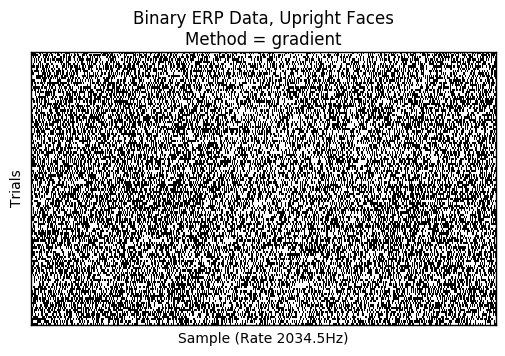

In [14]:
plot_binarised_data(data_X, "Upright Faces", method="gradient")

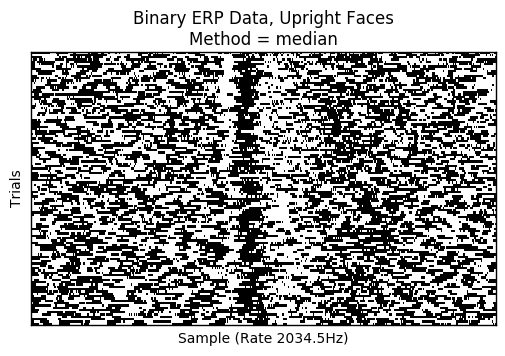

In [15]:
plot_binarised_data(data_X,"Upright Faces", method="median")

We will use the binarised data from the median split for now.

### Iterating for TPMs

Next, we will iterate through every time bin and in each time bin, iterate through every sample.  

Now this is going to sound very arbitrary, but we'll roll with it for now. We add the information from the data of the "present" state (i.e. the state at time $\tau$ after the current sample on our iteration) to a 4x4 state by state matrix. The states (rows) are in the LOLI form indicated in the pyphi documentation (in short: for a two-channel network XY, the rows progress from state 00 to 10 to 01 to 11 for the "past" state, and the same for columns except these correspond to the "present" state). We simply add one to the appropriate element of the matrix. We continue the accumulation for every sample.

We will also store the counts of each "past" state in a separate 4 x 1 column matrix.

Afterwards, we will divide our cumulative matrix (element by element) by the product matrix we just produced above to give our TPM. 

BUT we have a problem: we require conditional independence - see the note below. What we will do from here is convert this state by state TPM to a state by node TPM for input into `pyphi`. It's not ideal, but will do for now.

> As a note: `pyphi` requires that the TPM be in a state `x` node form, or a state `x` state form *with the constraint* that the nodes must be conditionally independent with regards to the past state: i.e. given a past state, the probability of a node in the present state being "on" must **not** depend on whether the *other* node in the present state is on.

> Logically, this makes sense; if the present state of a node is indeed dependent on the present state of the other node given the same past state, then there either must be "instantaneous" feedback, or there must be an external input. The conditional independence constraint means that every state `x` node TPM maps to a single state `x` state TPM.

> Unfortunately, for real-life data which is often messy, may not contain a sampling rate that fits perfectly with this conditionally-independent model, and will almost definitely have external inputs, this is troublesome. 

> What I have done (for now) is compute both the state `x` node and state `x` state TPMs and to return only the state by node TPM. I will print to the console the mean absolute difference between each element of the state `x` state TPM that the state `x` node TPM corresponds to, and the actual state `x` state TPM (though this is commented out for now). We'll see how this goes.

The function `get_tpm` will, for a single time bin of width $T$, calculate the TPM and output this in a state `x` node format.

We will bin the trials in bin widths of 10 trials. This helps with ensuring the TPM is at least reasonable by pooling across trials. Note that we only use the trial binning to calculate the TPM; the actual $\Phi$\* values are calculated on a per-trial basis (this is because `pyphi` requires a state to be specified for the subsystem).

In [16]:
def get_tpm(data_binary_X_group, data_binary_Y_group, tau):
    #from IPython.core.debugger import Tracer; Tracer()()
    """
    Only applicable for 2-channel scenario.
    data_binary_X: trial x sample integer binary array (0 or 1 only) for a single channel,
    number of samples equal to bin width T. Must be for a single group of 7 trials (sorted).
    data_binary_Y: trial x sample integer binary array (0 or 1 only) for a single channel,
    number of samples equal to bin width T. Must be for a single group of 7 trials (sorted).
    tau: the time lag that will be used to calculate the TPM (i.e. the time for "transition")
    NOTE: data_binary_X and data_binary_Y must be the same shape.
    RETURNS: state by node TPM.
    """
    
    if not data_binary_X_group.shape == data_binary_Y_group.shape:
        print("ERROR: two data array inputs must be the same shape!")
        return False
    
    # INITIALISE
    num_trials, num_samples = data_binary_X_group.shape # same as Y
    
    num_channels = 2
    num_states = num_channels ** 2
    
    tpm_cum = np.zeros((num_states, num_states))
    
    # Can this be vectorised? I can't think of an obvious way, but maybe can be looked into
    # to speed things up. If not, can also try using itertools to avoid the nested loop. 
    # Alternatively - maybe using zip and counter could speed things up? 
    for trial in range(0, num_trials):
        
        for sample in range(0, num_samples - tau):
            
            past_X = data_binary_X_group[trial, sample]
            past_Y = data_binary_Y_group[trial, sample]
            
            tpm_row = (2 * past_Y) + past_X
            
            present_X = data_binary_X_group[trial, sample + tau]
            present_Y = data_binary_Y_group[trial, sample + tau]
            
            tpm_col = (2 * present_Y) + present_X

            tpm_cum[tpm_row, tpm_col] += 1
            
    # Using zip and counter instead.
    # STILL TO BE TESTED
    #for sample in range(0, num_samples - tau):
        
    #    pasts_X = data_binary_X_group[0:num_trials, sample]
    #    pasts_Y = data_binary_Y_group[0:num_trials, sample]
       
    #    presents_X = data_binary_X_group[0:num_trials, sample + tau]
    #    presents_Y = data_binary_Y_group[0:num_trials, sample + tau]
      
    #    states_past = zip(pasts_X, pasts_Y)
    #    states_present = zip(presents_X, presents_Y)
    #    transitions = zip(states_past, states_present)
      
    #    for (past, present), count in Counter(transitions).items():
    #        row = 2 * past[1] + past[0]
    #        col = 2 * present[1] + present[0]
    #        tpm_cum[row, col] += count
    
    tpm_sbs = tpm_cum / tpm_cum.sum(axis=1, keepdims=True)
    
    tpm_sbn = pyphi.convert.state_by_state2state_by_node(tpm_sbs)
    
    #tpm_sbn = np.zeros((num_states, num_channels))
    #tpm_sbn[:, 0] = tpm_sbs[:, 1] + tpm_sbs[:, 3]
    #tpm_sbn[:, 1] = tpm_sbs[:, 2] + tpm_sbs[:, 3]

    # Print mean absolute difference between predicted and actual state by state TPM
    # tpm_sbs_predicted = pyphi.convert.state_by_node2state_by_state(tpm_sbn)
    # mean_abs_diff = np.mean(np.absolute(np.subtract(tpm_sbs, tpm_sbs_predicted)))
    # print(mean_abs_diff)
    
    return tpm_sbn

### $\Phi$ Calculation

In [17]:
def calculate_phi(tpm, state):
    """
    tpm: a 4x2 state by node TPM (as specified in pyphi documentation)
    state: a binary tuple of state (X, Y)
    RETURNS: a single float (phi value)
    """
    
    network = pyphi.Network(tpm)
    subsystem = pyphi.Subsystem(network, state, [0, 1]) # specify indices of included channels

    phi = pyphi.compute.big_phi(subsystem)
    
    return phi

### Gluing Things Together

Now we write a function to glue everything together. We will use the median split method.

In [41]:
def run_phi(data_X, data_Y, T, tau):
    """
    data_X and data_Y: the trial x sample ERP data.
    data_X and data_Y must be the same shape.
    T: the time bin width over which to calculate the TPM, in samples
    tau: time lag between transition states, in samples
    RETURNS: (bin centre by trial numpy array of phi values, bin centre values)
    """
    
    if not data_X.shape == data_Y.shape:
        print("ERROR: two data array inputs must be the same shape!")
        return False
    
    # Shuffle trials
    data_X = shuffle_data(data_X)
    data_Y = shuffle_data(data_Y)
    
    # Binarise data
    data_X = binarise_data_median(data_X)
    data_Y = binarise_data_median(data_Y)
    
    # INITIALISE
    num_trials, num_samples = data_X.shape # same as Y
    
    bin_start = 0 # in samples
    bin_centre = bin_start + (T//2)
    bin_end = bin_start + T
    
    # Number of trials per bin
    num_in_group = 4
    num_groups = num_trials // num_in_group - 1

    
    num_phi_values = num_samples // (T//2) - 1
    
    phi_values = np.zeros((num_phi_values, num_trials))
 
    bin_centre_values = []
    
    count = 0
    
    # ITERATE
    while bin_end <= num_samples:
        
        bin_centre_values.append(bin_centre)
        print(bin_centre)
    
        for group in range(0, num_groups):
            
            group_start = group * num_in_group
            group_end = group_start + num_in_group
    
            data_slice_X = data_X[group_start:group_end, bin_start:bin_end]
            data_slice_Y = data_Y[group_start:group_end, bin_start:bin_end]
        
            tpm = get_tpm(data_slice_X, data_slice_Y, tau)

            # Maybe can speed up by slicing only the bin centres, zipping, then mapping using phi?
            for trial in range(group_start, group_end):
                
                try:
                    centre_X = data_X[trial, bin_centre]
                    centre_Y = data_Y[trial, bin_centre]

                    state = (centre_X, centre_Y)

                    phi = calculate_phi(tpm, state)

                    phi_values[count, trial] = phi
                    
                except IndexError: # if iterating over trial in last group that doesn't exist
                    pass
        
        bin_start += (T//2)
        bin_centre += (T//2)
        bin_end += (T//2)
        count += 1
    
    # bin_centre_values is the actual time in ms (i.e. sample / 2.0345)
    # These are forced to be integers
    bin_centre_values = np.array(bin_centre_values)
    bin_centre_values = bin_centre_values // 2.0345
    
    return (phi_values, bin_centre_values)    

Now let's try running this on our Upright Faces data.

In [19]:
np.random.seed(0)
phi_upright, bin_centre_values = run_phi(data_X, data_Y, T, tau)

203
406
609
812
1015
1218
1421
1624
1827
2030
2233
2436
2639
2842


> The bin centre values are printed to the console. These are the SAMPLE bin centre values. The actual bin_centre_values variables contains the above numbers, divided by 2.0345.

Now let's try to visualise this briefly:

In [20]:
phi_upright.shape

(14, 118)

In [21]:
def visualise_phi(phi_values, bin_centre_values, description):
    """
    phi_values: bin_centre (in samples) by trial numpy array of phi_values
    """    
    # We transpose the matrix phi_values for easy comparison with our previous demo
    phi_values = np.transpose(phi_values)
    
    fig, ax1 = plt.subplots(1, 1)
    im = ax1.imshow(phi_values, extent=[bin_centre_values[0], bin_centre_values[-1], 0, 1180], 
              interpolation="none", cmap="viridis")
    ax1.set_yticks([])
    ax1.set_xlabel("Time Bin Centre\n (ms)")
    ax1.set_ylabel("Trials")
    ax1.set_title("".join(["Phi Values for Each Trial at Each Time Bin Centre\n", description]))
    fig.colorbar(im, ax=ax1)

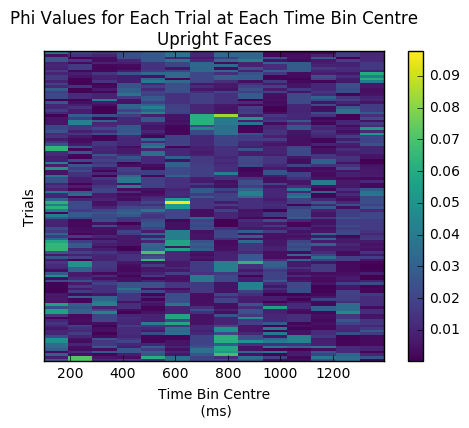

In [22]:
visualise_phi(phi_upright, bin_centre_values, "Upright Faces")

> Quick NB: the time bin centre's don't align very well on the x-axis as they have been specified here by the dimensions of the image, rather than by x ticks. Have a look at the actual bin centre values below:

In [23]:
print(bin_centre_values)

[   99.   199.   299.   399.   498.   598.   698.   798.   898.   997.
  1097.  1197.  1297.  1396.]


## Comparing with $\Phi$\*

Let's now compare these $\Phi$\ values with the $\Phi$\* values we obtained using Matlab.

Since our $\Phi$\* calculations were not state dependent, we binned trials into 7-trial bins. While we binned the trials in `pyphi` for the TPM calculations, the actual $\Phi$ calculations in `pyphi` here are per-trial. 

For comparability, we will separately find the mean $\Phi$ across all trials for the values obtained from Matlab, and those obtained from `pyphi`.

In [24]:
def find_phi_mean_matlab(data_matlab):
    """
    data_matlab: trial bin by sample bin array of phi values.
    RETURNS mean phi values (averaging across trials)    
    """
    
    phi_mean_array = np.mean(data_matlab, axis=0)
    
    return phi_mean_array

In [25]:
def find_phi_mean_python(data_python):
    """
    data_python: SAMPLE BIN by TRIAL array of phi values (NOTE DIFFERENT TO MATLAB)
    RETURNS mean phi values (averaging across trials) in TRIAL x SAMPLE BIN format
    (for comparability with matlab phi)
    """
    
    phi_mean_array = np.mean(data_python, axis=1)
    phi_mean_array = np.transpose(phi_mean_array)
    
    return phi_mean_array

Now we load the data:

In [26]:
data_dir = "../phi_star/"
data_name = "DEMO_phi_values.mat"

phi_matlab = sio.loadmat("".join([data_dir, data_name]), struct_as_record=False, squeeze_me=True)["processed"]

In [27]:
phi_matlab[0]._fieldnames

['bin_centres', 'values_trial_bins', 'values_H', 'values_I', 'values_phi']

In [28]:
phi_matlab_upright = phi_matlab[0].values_phi
phi_matlab_upright.shape

(29, 14)

> This is the data we want, but we only know this since we have checked in Matlab.

Taking the means:

In [29]:
phi_star_means = find_phi_mean_matlab(phi_matlab_upright)
phi_pyphi_means = find_phi_mean_python(phi_upright)

Visualising the means:

In [30]:
def visualise_mean_phi(phi_star_means, phi_pyphi_means, bin_centre_values):
    """
    Visualises the mean phi obtained from Matlab phi toolbox and pyphi.
    phi_star_means and phi_pyphi_means are numpy vectors of mean phi values.
    """
    
    # To make into 2D
    phi_star_means = np.expand_dims(phi_star_means, axis=0)
    phi_pyphi_means = np.expand_dims(phi_pyphi_means, axis=0)
    
    fig, (ax1, ax2) = plt.subplots(2, 1)
    im1 = ax1.imshow(phi_star_means, extent=[bin_centre_values[0], bin_centre_values[-1], 0, 200], 
              interpolation="none", cmap="viridis")
    im2 = ax2.imshow(phi_pyphi_means, extent=[bin_centre_values[0], bin_centre_values[-1], 0, 200], 
              interpolation="none", cmap="viridis")
    ax1.set_yticks([])
    ax2.set_yticks([])
    ax2.set_xlabel("Time Bin Centre\n (ms)")
    ax1.set_ylabel("Phi Star")
    ax2.set_ylabel("Phi using IIT 3.0")
    
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im1, cax=cax1)
    
    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im2, cax=cax2)

    fig.suptitle("Mean Phi Values for Phi Star and Phi from IIT 3.0")

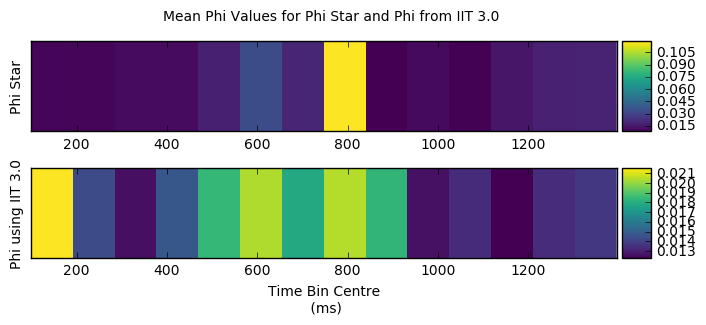

In [31]:
pylab.rcParams['figure.figsize'] = 8, 3
visualise_mean_phi(phi_star_means, phi_pyphi_means, bin_centre_values)

> Remember we've used random binning, so the results may vary slightly depending on the seed. Our number of trials in each bin - 4 - is probably small enough that random binning might make some rather large differences...again, ideally we would have all the data we can get, but this will do for now.

# Repeating for All Five Stimuli

Now, we simply do the above for the five stimuli.

In [32]:
T = 406
tau = 6

This can be done with a loop but since there are only five stimuli, it's probably not too hard to do this manually...

> NB: the seeds are kept here for reproducibility. Again, the small binning means that the seed might make perceivable differences, so bear that in mind.

## Inverse Faces

In [33]:
data_X = data_187["allERP"][0, 1][:, :]
data_Y = data_294["allERP"][0, 1][:, :]

In [34]:
np.random.seed(0)
phi_inverse, bin_centre_values = run_phi(data_X, data_Y, T, tau)

203
406
609
812
1015
1218
1421
1624
1827
2030
2233
2436
2639
2842


## Houses

In [35]:
data_X = data_187["allERP"][0, 2][:, :]
data_Y = data_294["allERP"][0, 2][:, :]

In [42]:
np.random.seed(0)
phi_house, bin_centre_values = run_phi(data_X, data_Y, T, tau)

203
406
609
812
1015
1218
1421
1624
1827
2030
2233
2436
2639
2842


## Tools

In [43]:
data_X = data_187["allERP"][0, 3][:, :]
data_Y = data_294["allERP"][0, 3][:, :]

In [44]:
np.random.seed(0)
phi_tool, bin_centre_values = run_phi(data_X, data_Y, T, tau)

203
406
609
812
1015
1218
1421
1624
1827
2030
2233
2436
2639
2842


## Mondrians

In [45]:
data_X = data_187["allERP"][0, 4][:, :]
data_Y = data_294["allERP"][0, 4][:, :]

In [46]:
np.random.seed(0)
phi_mondrian, bin_centre_values = run_phi(data_X, data_Y, T, tau)

203
406
609
812
1015
1218
1421
1624
1827
2030
2233
2436
2639
2842


## Packing into a Single Variable

In [47]:
phi_python = (phi_upright, phi_inverse, phi_house, phi_tool, phi_mondrian)

openfile = open('./pyphi_values.pckl', 'wb')
pickle.dump(phi_python, openfile)
openfile.close()

# To load, open the file with "rb" and load with the pickle.load() function.

# Visualising All Pyphi

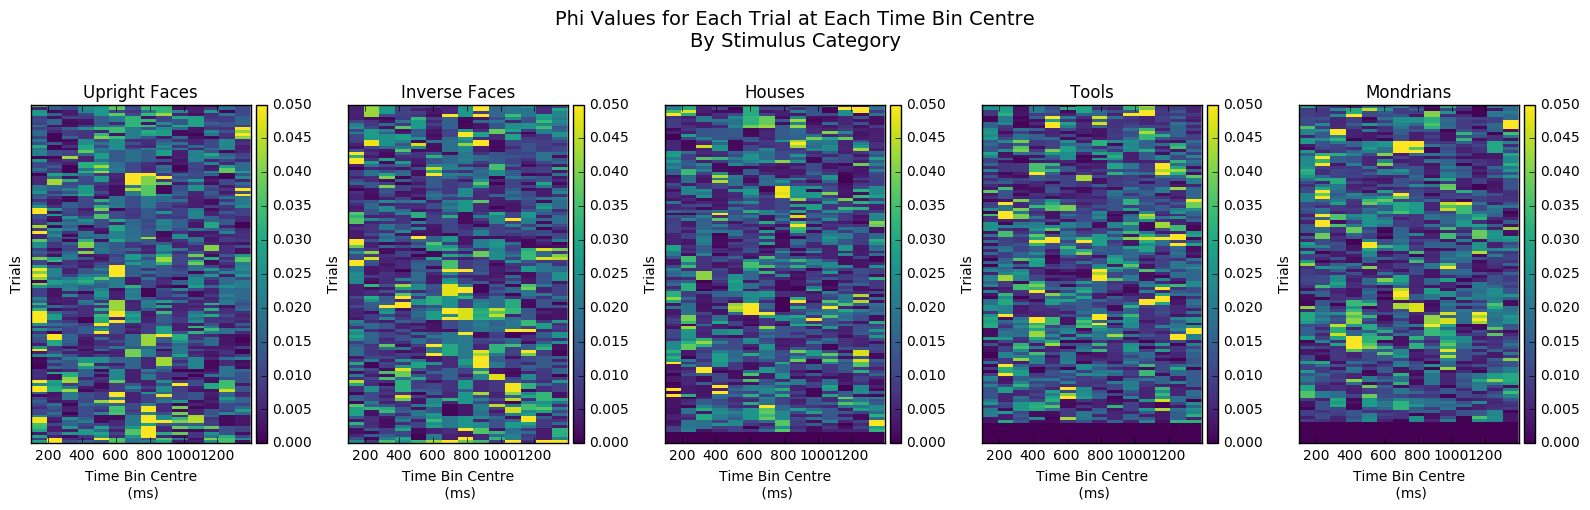

In [48]:
pylab.rcParams['figure.figsize'] = 16, 5.5

stimuli = ("Upright Faces", "Inverse Faces", "Houses", "Tools", "Mondrians")

fig, axes = plt.subplots(1, 5)
for i in range(0, 5): 
    
    im = axes[i].imshow(np.transpose(phi_python[i]), 
                   extent=[bin_centre_values[0], bin_centre_values[-1], 0, 2000], 
                   interpolation="none", cmap="viridis", vmin=0, vmax=0.05)
    axes[i].set_yticks([])
    axes[i].set_xlabel("Time Bin Centre\n (ms)")
    axes[i].set_ylabel("Trials")
    axes[i].set_title(stimuli[i])
    
    divider = make_axes_locatable(axes[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
fig.suptitle("".join(["Phi Values for Each Trial at Each Time Bin Centre\n", "By Stimulus Category"]), fontsize=14)
fig.tight_layout()

> For an individual colour bar for each plot, vmin and vmax can be changed above (though this doesn't seem to be much of an issue for these plots). 

And plotting:

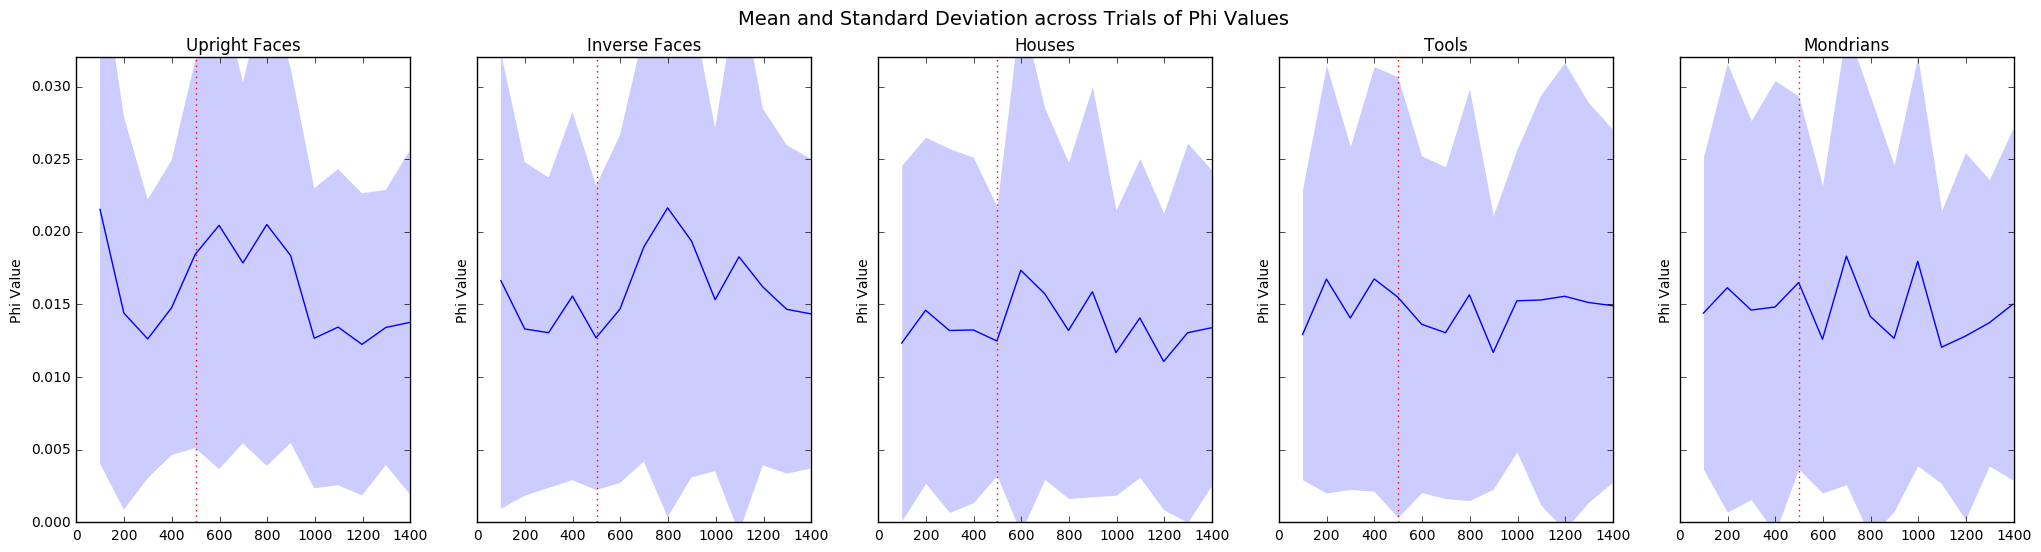

In [49]:
pylab.rcParams['figure.figsize'] = 25, 6

fig, axes = plt.subplots(1, 5, sharex=True, sharey=True)

for i in range(0, 5):

    mean = phi_python[i].mean(axis=1)
    std = phi_python[i].std(axis=1)

    axes[i].plot(bin_centre_values, mean)
    axes[i].fill_between(bin_centre_values, mean - std, mean + std, alpha=0.2, linewidth=0)
    axes[i].plot([500, 500], [0, 0.05], "r:")
    axes[i].set_ylabel("Phi Value")
    axes[i].set_title(stimuli[i])
    plt.ylim([0, 0.032])

fig.suptitle("Mean and Standard Deviation across Trials of Phi Values", fontsize=14)

# Comparing All Matlab Values with Python Values

In [50]:
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 20, 5

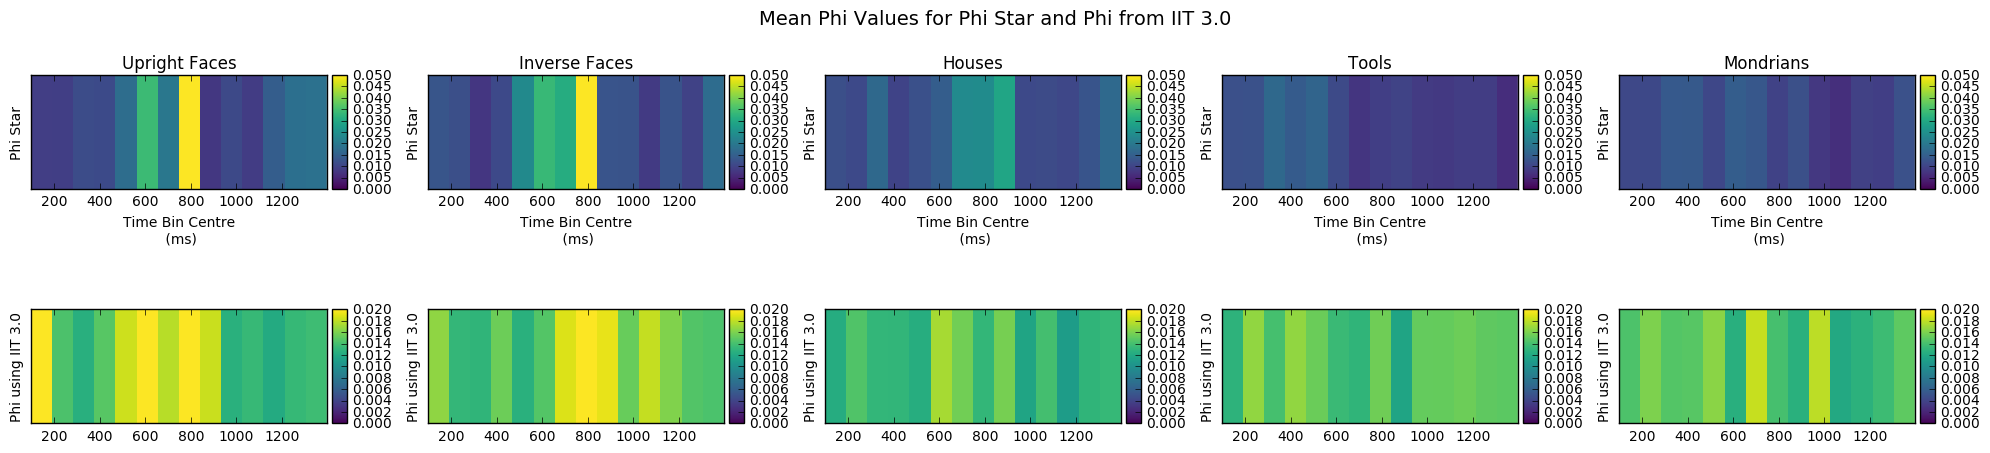

In [51]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

stimuli = ("Upright Faces", "Inverse Faces", "Houses", "Tools", "Mondrians")

fig, axes = plt.subplots(2, 5)
for i in range(0, 5):
    
    phi_star_means = find_phi_mean_matlab(phi_matlab[i].values_phi)
    phi_pyphi_means = find_phi_mean_python(phi_python[i])
    
    # To make into 2D
    phi_star_means = np.expand_dims(phi_star_means, axis=0)
    phi_pyphi_means = np.expand_dims(phi_pyphi_means, axis=0)
    
    im1 = axes[0, i].imshow(phi_star_means, extent=[bin_centre_values[0], bin_centre_values[-1], 0, 500], 
                         interpolation="none", cmap="viridis", vmin=0, vmax=0.05)
    im2 = axes[1, i].imshow(phi_pyphi_means, extent=[bin_centre_values[0], bin_centre_values[-1], 0, 500], 
                           interpolation="none", cmap="viridis", vmin=0, vmax=0.02)
    axes[0, i].set_yticks([])
    axes[1, i].set_yticks([])
    
    axes[0, i].set_xlabel("Time Bin Centre\n (ms)")
    
    axes[0, i].set_ylabel("Phi Star")
    axes[1, i].set_ylabel("Phi using IIT 3.0")
    
    axes[0, i].set_title(stimuli[i])
    
    divider1 = make_axes_locatable(axes[0, i])
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im1, cax=cax1)
    
    divider2 = make_axes_locatable(axes[1, i])
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im2, cax=cax2)

fig.suptitle("Mean Phi Values for Phi Star and Phi from IIT 3.0", fontsize=14)
    
fig.tight_layout()

> Do note that the colour axes are not the same between the two plots; this is for visibility.

And comparing with a scatter plot:

In [52]:
def visualise_matlab_vs_python(data_matlab, data_python, description):
    """
    data_matlab: 1 x 5 array of phi values from matlab.
    data_phi: 1 x 5 tuple of phi values from PyPhi.
    description: string for title descriptor
    """
    
    phi_matlab_values = [find_phi_mean_matlab(data_matlab[x].values_phi) for x in range(0, 5)]
    phi_python_values = [find_phi_mean_python(data_python[x]) for x in range(0, 5)]
    
    data_matlab = np.concatenate(phi_matlab_values)
    data_python = np.concatenate(phi_python_values)
    
    flat_matlab = data_matlab.flatten()
    flat_python = data_python.flatten()
    
    # For least-squares line of best fit
    fit = np.polyfit(flat_python, flat_matlab, 1)
    fit_fun = np.poly1d(fit)
    
    plt.plot(flat_python, flat_matlab, "b.", 
             flat_python, fit_fun(flat_python), "r")
    plt.title("".join(["Matlab Phi vs Python Phi\n", description]))
    plt.xlabel("Python Phi")
    plt.ylabel("Matlab Phi")
    
    # Make axis limits
    _, ymax = plt.gca().get_ylim()
    _, xmax = plt.gca().get_xlim()
    both_max = max(ymax, xmax)
    plt.gca().set_ylim((0, both_max))
    plt.gca().set_xlim((0, both_max))
    plt.gca().set_aspect('equal')

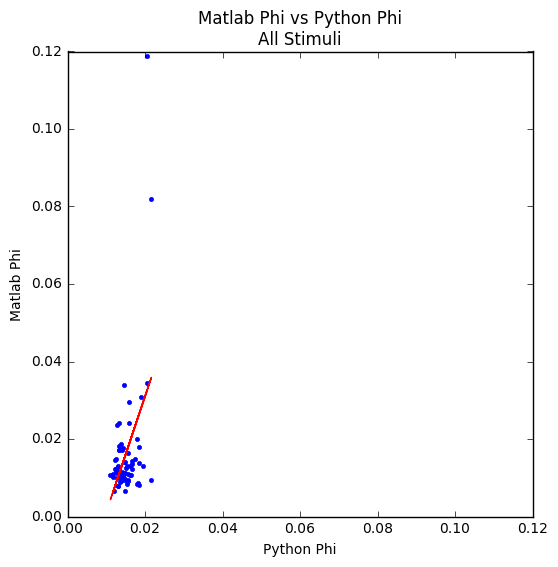

In [53]:
pylab.rcParams['figure.figsize'] = 8, 6
visualise_matlab_vs_python(phi_matlab, phi_python, "All Stimuli")